### Viscoelastic contact with consrained conjugate gradient method and simplified one-branch Bugnicourt(2017)

Based on the discussion on 29/03/2024, we have determined several parameters like shear modulus $G$ and Prony series for zener model with Kelvin representation, and we apply a comparison with Hertz solution for Kelvin representation.

![](figures/Representation_of_the_Standard_Linear_Solid.jpg)

Let's analysis step by step. First we consider an elastic material to check our backward Euler method.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
#define input parameters
##time
t0 = 0
t1 = 1
dt = (t1 - t0)/50
##load(constant)
W = 1e0  # Total load

#domain size
R = 1  # Radius of demi-sphere
L = 2  # Domain size
Radius = 0.5
S = L**2  # Domain area

# Generate a 2D coordinate space
n = 300
m = 300

x, y = np.meshgrid(np.linspace(0, L, n, endpoint=False), np.linspace(0, L, m, endpoint=False))

x0 = 1
y0 = 1


First we explain the shear modulus with Laplace transform, we start with the differential formulation for viscoelasticity:

$$
s\left(1+\frac{G_1}{G_0}\right)+\frac{\eta_1}{G_0} \dot{s}=2 G_1 e+2 \eta_1 \dot{e}
$$

When we assume shear modulus $G = 1$, and use combination of $G_0$ and $G_1$, we can apply Boussinesq potential in the Laplace domain, going back to the real domain, the viscoelastic Boussinesq equation can be given:

$$
\iint_{\Omega} \frac{1}{4 \pi \rho}\left(P(\xi, \eta)\left(1+\frac{G_1}{G_0}\right)+\frac{\eta_1}{G_0} \dot{P}(\xi, \eta)\right) d \xi d \eta=G_1 U_z(x, y)+\eta_1 \dot{U}_z(x, y)
$$

With $G = 1$ and Lamé parameters relationship for homogeneous isotropic linear elastic materials:

$$
E  =2 G(1+v)
$$

In [25]:
E = 3  # Young's modulus
nu = 0.5
E_star = E / (1 - nu**2)  # Plane strain modulus

In [26]:

##################################################################
#####First just apply for demi-sphere and compare with Hertz######
##################################################################

# We define the distance from the center of the sphere
r = np.sqrt((x-x0)**2 + (y-y0)**2)

# Define the kernel in the Fourier domain
q_x = 2 * np.pi * np.fft.fftfreq(n, d=L/n)
q_y = 2 * np.pi * np.fft.fftfreq(m, d=L/m)
QX, QY = np.meshgrid(q_x, q_y)

kernel_fourier = np.zeros_like(QX)
kernel_fourier = 2 / (E_star * np.sqrt(QX**2 + QY**2))
kernel_fourier[0, 0] = 0  # Avoid division by zero at the zero frequency


h_profile = -(r**2)/(2*Radius)

def apply_integration_operator(Origin, kernel_fourier, h_profile):
    # Compute the Fourier transform of the input image
    Origin2fourier = np.fft.fft2(Origin, norm='ortho')

    Middle_fourier = Origin2fourier * kernel_fourier

    Middle = np.fft.ifft2(Middle_fourier, norm='ortho').real

    Gradient = Middle - h_profile

    return Gradient, Origin2fourier#true gradient


/tmp/ipykernel_2846618/32090082.py:14: RuntimeWarning: divide by zero encountered in true_divide
  kernel_fourier = 2 / (E_star * np.sqrt(QX**2 + QY**2))


In [27]:
def contact_solver(n, m, W, S, E_star, h_profile, tol=1e-6, iter_max=200):
    

    # Initial pressure distribution
    P = np.full((n, m), W / S)  # Initial guess for the pressure

    #initialize the search direction
    T = np.zeros((n, m))

    #set the norm of surface(to normalze the error)
    h_rms = np.std(h_profile)

    #initialize G_norm and G_old
    G_norm = 0
    G_old = 1

    #initialize delta
    delta = 0

    # Initialize variables for the iteration
    k = 0  # Iteration counter
    error = np.inf  # Initialize error
    h_rms = np.std(h_profile)

    while np.abs(error) > tol and k < iter_max:
    # try np.where(P > 0) to find the contact area
        S = P > 0

        #encapsulate into a function

        # Calculate the gap G(as Gradient, see Lucas(2020)) in the Fourier domain and transform it back to the spatial domain
        #P_fourier = np.fft.fft2(P, norm='ortho')
        #G_fourier = P_fourier * kernel_fourier
        #G = np.fft.ifft2(G_fourier, norm='ortho').real - h_profile
        ##function

        G, P_fourier = apply_integration_operator(P, kernel_fourier, h_profile)

        G -= G[S].mean()

        G_norm = np.linalg.norm(G[S])**2

        # Calculate the search direction
        T[S] = G[S] + delta * G_norm / G_old * T[S]
        T[~S] = 0  ## out of contact area, dont need to update
        ## size dont match

        # Update G_old
        G_old = G_norm

        # Set R
        R, T_fourier  = apply_integration_operator(T, kernel_fourier, h_profile)
        R += h_profile
        R -= R[S].mean()

        # Calculate the step size tau
        #######
        tau = np.vdot(G[S], T[S]) / np.vdot(R[S], T[S])

        # Update P
        P -= tau * T        
        P *= P > 0

        # identify the inadmissible points
        R = (P == 0) & (G < 0)

        if R.sum() == 0:
            delta = 1
        else:
            delta = 0#change the contact point set and need to do conjugate gradient again

        # Apply positive pressure on inadmissible points       
        #P[R] -= tau * G[R]


        # Enforce the applied force constraint
        P = W * P / np.mean(P) / L**2  ## be wise here#############
        ##############################



        # Calculate the error for convergence checking
        error = np.vdot(P, (G - np.min(G))) / (P.sum()*h_rms) 
        print(delta, error, k, np.mean(P), np.mean(P>0), tau)
        
        k += 1  # Increment the iteration counter


    # Ensure a positive gap by updating G
    G = G - np.min(G)

    displacement_fourier = P_fourier * kernel_fourier
    displacement = np.fft.ifft2(displacement_fourier, norm='ortho').real

    return displacement, P



In [28]:
#first we only consider one branch
G_0 = 2.75  # MPa
G_1 = 2.75  # MPa
G_inf = 1/(1/G_0 + 1/G_1)  # MPa

print('G_inf:', G_inf)

G_inf: 1.375


The relaxation time  $\tau_0$ (or called the characteristic time of the creep compliance function[1]) is typically defined as the ratio of the dashpot's viscosity $\eta_0$ to the spring's modulus $G_1$ that it is in parallel with, not the series spring modulus $G_0$. So, it would be:

$$ \tau_0 = \frac{\eta_1}{G_1} $$

Then for elastic material, $\tau_0$ should be set 0.

In [29]:
tau_0 = .1  # s
eta_1 = G_1 * tau_0  # Characteristic time

##### If $\tau_0 = 0$, it is equivalent to an elastic problem, and we expect:
![](figures/what_we_expect_elastic.jpg)

#### Viscoelastic contact routine (Bugnicourt et al. 2017) for multi-branch (Generalized) Kelvin model 

- **Input:** 
  - External load $W_{t+\Delta t}$
  - Timestep $\Delta t$
  - Partial displacements $\mathbb{M}_t^k = A_{z z} P_t^k$
  - Displacement $\mathbb{U}_t$
  - Surface $\mathbb{H}$
  - Material properties $G_\infty$, $G_{0,1}^k$, $\eta^k$

- **Steps:**
  1. Calculate $\alpha$ as follows:
     $$\alpha = G_\infty + \sum_k{\frac{G_1^k + \frac{\eta^k}{\Delta t}}{1 + \frac{G_1^k}{G_0^k} + \frac{\eta^k}{G_0^k\Delta t}}}$$
  2. Calculate $\beta$ as follows:
     $$\beta = \sum_k{\frac{\frac{\eta^k}{\Delta t}}{1 + \frac{G_1^k}{G_0^k} + \frac{\eta^k}{G_0^k\Delta t}}}$$
  3. For each $k$, calculate $\gamma^k$ as follows:
     $$\gamma^k = \frac{\frac{\eta^k}{G_0^k\Delta t}}{1 + \frac{G_1^k}{G_0^k} + \frac{\eta^k}{G_0^k\Delta t}}$$
  4. Update $\mathbb{H}_{t+\Delta t}$ using $\alpha$, $\beta$, and $\gamma^k$:
     $$\mathbb{H}_{t+\Delta t} = \alpha\mathbb{H} - \beta \mathbb{U}_t + \sum_k \gamma^k \mathbb{M}_t^k$$
  5. Solve elastic contact for $W_{t + \Delta t}$ and $\mathbb{H}_{t + \Delta t}$, obtain $\mathbb{U}_{t + \Delta t}$
  6. Solve for $\mathbb{M}_{t + \Delta t}^k$:
     $$\mathbb{M}_{t + \Delta t}^k \left(1 + \frac{G_1^k}{G_0^k}\right) + \frac{\eta^k}{G_0^k\Delta t}(\mathbb{M}_{t + \Delta t}^k - \mathbb{M}_t^k) = G_1^k \mathbb{U}_{t + \Delta t} + \frac{\eta^k}{\Delta t}(\mathbb{U}_{t + \Delta t} - \mathbb{U}_t)$$



#### Briefly speaking, for a generalized Kelvin model, we have:

##### Step1: Update surface profile $H_t$
##### Step2: Update displacement $U_t$ with our existed solver
##### Step3: Update partial displacement $M^k_t$ as integration of $P^k_t$(no need to update $P^k_t$ directly)

####

Another thing that needs to be clarified is that they use generalized zener model and our algorithm validates for Kelvin model.

#### Since we are dealing with one-branch Kelvin model, we can have:

$\alpha$

In [30]:
#######################################
###if we let k_branch=1, we can compare the real contact area with hertz solution at t=0 and t>>\tau_0
#######################################
k_branch = 1

alpha = G_inf + (G_1 + eta_1/dt)/(1 + G_1/G_0 + eta_1/G_0/dt)
#alpha = 1/2 * alpha
print('alpha:', alpha)
print('G_inf * 2:', G_inf*2)

beta = (eta_1/dt)/(1+G_1/G_0+eta_1/G_0/dt)
gamma = (eta_1/G_0/dt)/(1+G_1/G_0+eta_1/G_0/dt)

Surface = h_profile

alpha2 = (G_1 + eta_1/dt)/(1 + G_1/G_0 + eta_1/G_0/dt)
#beta2 = gamma#(eta_1/G_0/dt)/(1+G_1/G_0+eta_1/G_0/dt)
#gamma2 = beta#(eta_1/dt)/(1+G_1/G_0+eta_1/G_0/dt)


U = np.zeros((n, m))
M = np.zeros((n, m))

Ac=[]

for t in np.arange(t0, t1, dt):
    #main step0: Update the effective modulus
    #effictive modulus
    #G_t = G_inf + G_1 * np.exp(-t/tau_0)

    #E_star = G_t
    

    #main step1: Update the surface profile
    H_new = alpha2*Surface - beta*U + gamma*M

    #main step2: Update the displacement field
    M_new, P = contact_solver(n, m, W, S, E_star, H_new, tol=1e-6, iter_max=200)
    ###const no need to update the loading field W_new


    Ac.append(np.mean(P > 0)*S)

    U_new = (1/alpha2)*(M_new - gamma*M + beta*U)

    M = M_new
    #main step4: Update the total displacement field
    U = U_new

alpha: 3.732142857142857
G_inf * 2: 2.75
1 0.5398112564251819 0 0.25 0.5360111111111111 6.558428532876984
1 0.2788976010255409 1 0.25000000000000006 0.30743333333333334 9.453288939951085
1 0.14926787308227057 2 0.25000000000000006 0.1953 11.405917189144764
1 0.07295486401795771 3 0.25 0.13872222222222222 13.914654279325196
1 0.02508023381468447 4 0.25 0.11236666666666667 17.507055068274624
1 0.002701647447725412 5 0.25 0.10076666666666667 27.523782599894957
1 0.003351434050610731 6 0.25 0.09614444444444445 51.462276608998664
1 0.005332833402889024 7 0.24999999999999997 0.09392222222222223 38.00042328992621
1 0.0007933202175897974 8 0.25000000000000006 0.09347777777777778 38.54434996035025
1 0.0007816443230287137 9 0.25000000000000006 0.09276666666666666 56.46215353472813
1 0.0002428565065316961 10 0.24999999999999997 0.09223333333333333 83.28632008171951
1 0.0005527023172970163 11 0.24999999999999997 0.09205555555555556 45.63873222743947
1 0.00019405022225673372 12 0.25000000000000006 

1 0.0005866197818646721 11 0.25 0.1049 52.190307648013736
1 8.930512383862405e-05 12 0.25 0.10472222222222222 42.99480739320271
1 0.00012293833516758778 13 0.25000000000000006 0.10445555555555555 68.31767390044926
1 0.00012622114564771948 14 0.25 0.10445555555555555 47.82669440364374
1 0.00014892856739003792 15 0.25000000000000006 0.10436666666666666 51.69357318936503
1 4.51029566845745e-05 16 0.24999999999999997 0.10427777777777777 55.22073007565578
1 6.972927480905649e-05 17 0.25 0.10418888888888889 40.205656419953186
1 5.36926094103699e-05 18 0.25 0.10418888888888889 98.37259854371726
1 2.3921737233843807e-05 19 0.25 0.10418888888888889 35.83041424745899
1 2.802146499628873e-05 20 0.25000000000000006 0.10418888888888889 82.19851227400702
1 2.7168220280469726e-05 21 0.24999999999999992 0.10418888888888889 41.99836784199907
1 2.621293431273298e-05 22 0.25 0.10418888888888889 62.53451627178851
1 6.084604914314574e-06 23 0.24999999999999997 0.10418888888888889 52.53980202295612
1 1.1009

Hertz solution for one-branch viscoelastic model with Kelvin representation. 

/tmp/ipykernel_2846618/930064292.py:17: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(x[n//2], p0_t0*np.sqrt(1 - (x[n//2]-x0)**2 / a_t0**2))
/tmp/ipykernel_2846618/930064292.py:18: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(x[n//2], p0_t_inf*np.sqrt(1 - (x[n//2]-x0)**2 / a_t_inf**2))


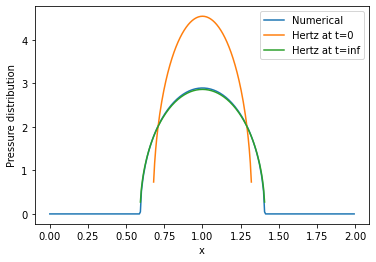

In [31]:
#######################################
###Hertzian contact theory reference
#######################################
##Hertz solution at t0    
E_effective_t0 = 2*G_0*(1+nu)/(1-nu**2)

p0_t0 = (6*W*(E_effective_t0)**2/(np.pi**3*Radius**2))**(1/3)
a_t0 = (3*W*Radius/(4*(E_effective_t0)))**(1/3)
##Hertz solution at t_inf
E_effective_inf = 2*G_inf*(1+nu)/(1-nu**2)

p0_t_inf = (6*W*(E_effective_inf)**2/(np.pi**3*Radius**2))**(1/3)
a_t_inf = (3*W*Radius/(4*(E_effective_inf)))**(1/3)


plt.plot(x[n//2], P[n//2])
plt.plot(x[n//2], p0_t0*np.sqrt(1 - (x[n//2]-x0)**2 / a_t0**2))
plt.plot(x[n//2], p0_t_inf*np.sqrt(1 - (x[n//2]-x0)**2 / a_t_inf**2))
plt.legend(["Numerical", "Hertz at t=0", "Hertz at t=inf"])
plt.xlabel("x")
plt.ylabel("Pressure distribution")
plt.show()

Ac_hertz_t0 = np.pi*a_t0**2
Ac_hertz_t_inf = np.pi*a_t_inf**2

Analytical contact area radius at t0: 0.32424965862401395
Analytical contact area radius at t_inf: 0.4085289703216219
Analytical maximum pressure at t0: 4.541322364996685
Analytical maximum pressure at t_inf: 2.8608538210088463
Numerical contact area at t0: 0.3660888888888889
Numerical contact area at t_inf 0.5212888888888889
Analyical contact area at t0: 0.3303002692699386
Analyical contact area at t_inf: 0.5243189949044802


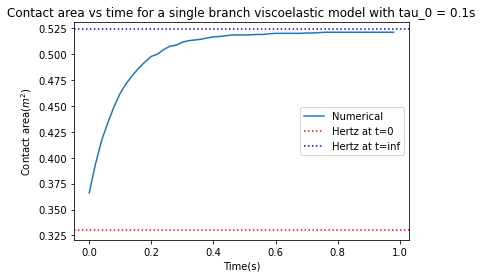

In [32]:
print("Analytical contact area radius at t0:", a_t0)
print("Analytical contact area radius at t_inf:", a_t_inf)
print("Analytical maximum pressure at t0:", p0_t0)
print("Analytical maximum pressure at t_inf:", p0_t_inf)
print("Numerical contact area at t0:", Ac[0])
print("Numerical contact area at t_inf",  Ac[-1])
print("Analyical contact area at t0:", Ac_hertz_t0)
print("Analyical contact area at t_inf:", Ac_hertz_t_inf)
plt.plot(np.arange(t0, t1, dt), Ac)
plt.axhline(Ac_hertz_t0, color='red', linestyle='dotted')
plt.axhline(Ac_hertz_t_inf, color='blue', linestyle='dotted')
plt.xlabel("Time(s)")
plt.ylabel("Contact area($m^2$)")
plt.legend(["Numerical", "Hertz at t=0", "Hertz at t=inf"])
#define a title that can read parameter tau_0
plt.title("Contact area vs time for a single branch viscoelastic model with tau_0 = " + str(tau_0) + "s")
#plt.axhline(Ac_hertz_t_inf, color='blue')
plt.show()

### Reference:

[1] Bugnicourt, R., P. Sainsot, N. Lesaffre, and A.A. Lubrecht. ‘Transient Frictionless Contact of a Rough Rigid Surface on a Viscoelastic Half-Space’. Tribology International 113 (September 2017): 279–85. https://doi.org/10.1016/j.triboint.2017.01.032.

[2] Van Dokkum, Jan Steven, and Lucia Nicola. ‘Green’s Function Molecular Dynamics Including Viscoelasticity’. Modelling and Simulation in Materials Science and Engineering 27, no. 7 (1 October 2019): 075006. https://doi.org/10.1088/1361-651X/ab3031.

[3] https://mp.weixin.qq.com/s?__biz=MzI1OTkxMzc4OQ==&mid=2247498108&idx=1&sn=d90bdb70d1071b351687a504ba530157&scene=21#wechat_redirect

[4] https://mp.weixin.qq.com/s/9kCxj8HkuDdGX1_f8wZ54A

